# Data Preprocessing 
-  Combining price and occupancy data 

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

mpl.rcParams['figure.figsize'] = (30, 10)
mpl.rcParams['axes.grid'] = False

In [8]:
# hotels with decent amount of data
clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 

In [2]:
df1 = pd.read_pickle('dataset/raw/pms_price_01.pkl')
df2 = pd.read_pickle('dataset/raw/pms_price_02.pkl')
df3 = pd.read_pickle('dataset/raw/pms_price_03.pkl')
df4 = pd.read_pickle('dataset/raw/pms_price_04.pkl')
df5 = pd.read_pickle('dataset/raw/pms_price_05.pkl')
df6 = pd.read_pickle('dataset/raw/pms_price_06.pkl')
df_occ = pd.read_pickle('dataset/raw/pms_occupancy.pkl')

In [3]:


def preprocess_price(dx):
    clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 

    # filter clean hotels
    dx = dx[dx['HotelId'].isin(clean_hotels)]
    # Object to datetime 
    dx['TargetDate'] = pd.to_datetime(dx['TargetDate'],format="%Y-%m-%d")
    dx['SnapshotDate'] = pd.to_datetime(dx['SnapshotDateTime'].dt.date,format="%Y-%m-%d")
    # Create new Column
    dx['LeadTime'] = (dx['TargetDate']-dx['SnapshotDate']).astype('timedelta64[D]')
    # Only consider 90 days development
    dx = dx[dx['LeadTime']<90]
    # Drop rows with snapshot date grater then targetdate 
    dx = dx[dx['SnapshotDate']<=dx['TargetDate']]
    # sorting
    dx = dx.sort_values(by=['HotelId','TargetDate','SnapshotDateTime','LAR'], ascending=True)
    # Droping SnapshotDateTime because we don't need time component
    dx = dx.drop(columns=['SnapshotDateTime'])
    # for ADR
    adr = dx.groupby(['HotelId','TargetDate','SnapshotDate']).mean().reset_index()['LAR'].values
    # for LAR
    dx = dx.drop_duplicates(subset=['HotelId','TargetDate','SnapshotDate'],keep='last')
    dx['ADR'] = adr
    return dx

def preprocess_occ(dx):
    clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 
    # filter clean hotels
    dx = dx[dx['HotelId'].isin(clean_hotels)]
    # Object to datetime 
    dx['TargetDate'] = pd.to_datetime(dx['TargetDate'],format="%Y-%m-%d")
    dx['SnapshotDate'] = pd.to_datetime(dx['SnapshotDateTime'].dt.date,format="%Y-%m-%d")
    # Create new Column
    dx['LeadTime'] = (dx['TargetDate']-dx['SnapshotDate']).astype('timedelta64[D]')
    # Only consider 90 days development
    dx = dx[dx['LeadTime']<90]
    # Drop rows with snapshot date grater then targetdate 
    dx = dx[dx['SnapshotDate']<=dx['TargetDate']]
    # sorting
    dx = dx.sort_values(by=['HotelId','TargetDate','SnapshotDateTime','Definitive'], ascending=True)
    # Droping SnapshotDateTime because we don't need time component
    dx = dx.drop(columns=['SnapshotDateTime'])
    # Removing duplicate entries
    dx = dx.drop_duplicates(subset=['HotelId','TargetDate','SnapshotDate'],keep='last')
    return dx

In [4]:
# preprocessing
df1 = preprocess_price(df1)
df2 = preprocess_price(df2)
df3 = preprocess_price(df3)
df4 = preprocess_price(df4)
df5 = preprocess_price(df5)
df6 = preprocess_price(df6)
df_occ = preprocess_occ(df_occ)

# combining dataframe 
df_lar = df1.append(df2,ignore_index=True)
df_lar = df_lar.append(df3,ignore_index=True)
df_lar = df_lar.append(df5,ignore_index=True)
df_lar = df_lar.append(df4,ignore_index=True)
df_lar = df_lar.append(df6,ignore_index=True)

In [5]:
df_occ.to_pickle('dataset/preprocessed/occupancy.pkl')
df_lar.to_pickle('dataset/preprocessed/price.pkl')

## Combining Price and Occupancy dataset

In [6]:
df = pd.merge(df_occ, df_lar, left_on=['HotelId','TargetDate','SnapshotDate','LeadTime'], right_on=['HotelId','TargetDate','SnapshotDate','LeadTime'], how='outer')

In [7]:
df = df.drop(columns=['SnapshotDate'])
df = df.rename(columns={'TargetDate':'DOA','LeadTime':'DBA','Definitive':'ROH'})
df = df[['HotelId','DOA','DBA','LAR','ADR','Rooms','ROH']]

In [8]:
df = df.drop_duplicates(subset=['HotelId','DOA','DBA'],keep='last')

In [9]:
## store raw combined
df.to_pickle('dataset/preprocessed/combined.pkl')

## Imputation

In [5]:
df = pd.read_pickle('dataset/preprocessed/combined.pkl')

In [6]:
def fill(dx,col):
    dx = dx.pivot(index='DOA',columns='DBA',values=col)
    dx = dx.bfill(axis=1).ffill(axis=1)
    dx.columns = dx.columns[::-1]
    return dx.stack()

def imputation(dx):
    ROH   = fill(dx,'ROH')
    LAR   = fill(dx,'LAR')
    ADR   = fill(dx,'ADR')
    Rooms = fill(dx,'Rooms')
    
    _DOA   = []
    _ROH   = []
    _LAR   = []
    _ADR   = []
    _Rooms = []
    _DBA = []

    null_arr = np.empty(90)
    null_arr[:] = np.NaN
    DBA = np.arange(start=89, stop=-1, step=-1)
    target_doa = dx['DOA'].dt.strftime('%Y-%m-%d').unique()
    for DOA in tqdm_notebook(target_doa,desc='Imputing Target Date'):
        _DOA = np.append(_DOA,np.full((90),DOA))
        _DBA = np.append(_DBA,DBA)

        if(len(LAR.loc[DOA])==0):
            _LAR = np.append(_LAR,null_arr)
        else:
            _LAR = np.append(_LAR,LAR.loc[DOA].values)
        if(len(ADR.loc[DOA])==0):
            _ADR = np.append(_ADR,null_arr)
        else:
            _ADR = np.append(_ADR,ADR.loc[DOA].values)
        # _ADR = np.append(_ADR,ADR.loc[DOA].values)
        _Rooms = np.append(_Rooms,Rooms.loc[DOA].values)
        _ROH = np.append(_ROH,ROH.loc[DOA].values)

    df = pd.DataFrame({
        "DOA":_DOA,
        "DBA":_DBA,
        "LAR":_LAR,
        "ADR":_ADR,
        "Rooms":_Rooms,
        "ROH":_ROH,
    })
    df['DBA'] = df['DBA'].astype('float') 
    df['LAR'] = df['LAR'].astype('float') 
    df['ADR'] = df['ADR'].astype('float') 
    df['Rooms'] = df['Rooms'].astype('float') 
    df['ROH'] = df['ROH'].astype('float') 

    return df

In [9]:
for hotel_id in tqdm_notebook(clean_hotels,desc='Hotel Id'):
    dx = df[(df['HotelId'] == hotel_id)&(df['DOA'] <= '2019-12-31')]
    dx = dx.drop(columns=['HotelId'])
    imputation(dx).to_pickle('dataset/preprocessed/'+str(hotel_id)+'_imputed.pkl')

# Clean Up outliers

In [111]:
hotelId = '4290'
df = pd.read_pickle('dataset/preprocessed/'+hotelId+'_imputed.pkl')

In [112]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DBA,65700.0,44.500000,25.979356,0.0,22.00,44.5,67.0,89.0
LAR,64440.0,186.161132,64.360419,90.0,141.91,170.0,212.5,518.7
ADR,64530.0,186.248879,64.384575,90.0,141.91,170.0,212.5,530.0
Rooms,65700.0,57.311081,23.825154,32.0,48.00,53.0,53.0,149.0
ROH,65700.0,28.005327,22.820629,0.0,12.00,24.0,40.0,161.0


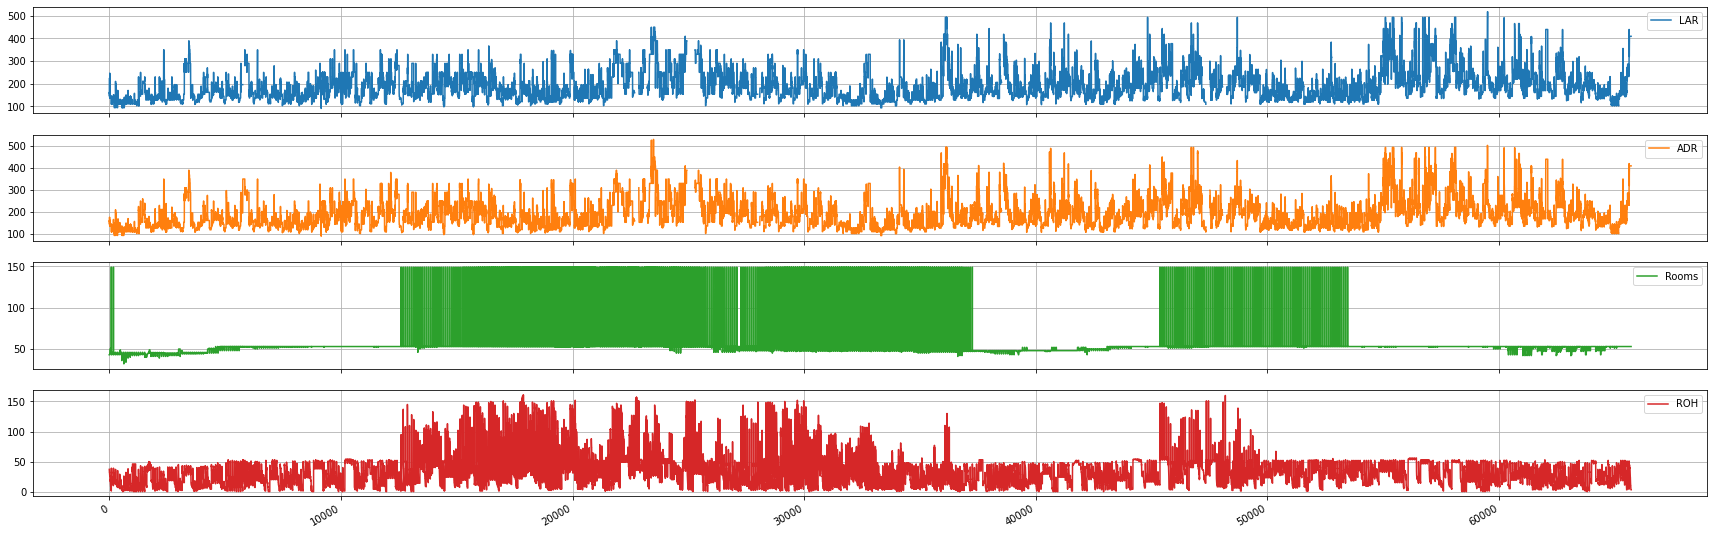

In [113]:
plot_cols = ['LAR', 'ADR', 'Rooms','ROH']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True,grid=True)

In [107]:
df[df['LAR'] > 500]

,DOA,DBA,LAR,ADR,Rooms,ROH
20340,2018-08-15,89.0,888.64,888.64,115.0,114.0
23337,2018-09-17,62.0,598.60,598.60,115.0,71.0
23338,2018-09-17,61.0,598.60,598.60,115.0,71.0
23339,2018-09-17,60.0,598.60,598.60,115.0,71.0
23340,2018-09-17,59.0,598.60,598.60,115.0,71.0
...,...,...,...,...,...,...
30962,2018-12-11,87.0,888.64,888.64,115.0,115.0
30963,2018-12-11,86.0,888.64,888.64,115.0,115.0
30964,2018-12-11,85.0,888.64,888.64,115.0,113.0
31050,2018-12-12,89.0,888.64,253.87,115.0,113.0


In [108]:
df.loc[df['LAR'] > 500, 'LAR'] = df['LAR'].median()
df.loc[df['ADR'] > 500, 'ADR'] = df['ADR'].median()

In [109]:
df.to_pickle('dataset/preprocessed/'+hotelId+'_imputed.pkl')